In [1]:
from __future__ import print_function, division

import numpy as np
import time
import os
import copy
import PIL
import sys
import pickle

from tqdm import tqdm_notebook as tqdm
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.optim import lr_scheduler
from torchsummary import summary

import torchvision
from torchvision import datasets, models, transforms
#from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize
#from albumentations.pytorch import ToTensor


# Plots
import matplotlib.pyplot as plt
%matplotlib inline

plt.ion()   # interactive mode

In [2]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_palette(sns.color_palette("Set2", 10))
sns.set_style("whitegrid", {'axes.grid' : False})

## Local functions

In [3]:
from dataset import *
from train import train_model
from show import *
from constants import *

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Constants

In [5]:
SEED = 238122

# Loading Data

## Transform data

In [6]:
dataset = FacadesDatasetH5Patches(to_file_path('images', 'hdf5'), normalized=True)

# Validation Set

In [7]:
num_crops_per_images = pickle.load(open(to_file_path('crops', 'p'), "rb" ))
crops_from_to_idx = []
from_ = 0
to = 0
for n in num_crops_per_images:
    to += n
    crops_from_to_idx.append((from_, to))
    from_ += n

In [8]:
def img_idx_to_crop_idx(indices):
    return np.array([j for i in indices for j in range(*crops_from_to_idx[i])])

In [9]:
def lenghts_split(size, perc):
    train_l =  int(0.9 * size)
    return train_l, size - train_l

In [10]:
np.random.seed(SEED)
img_indices = np.random.permutation(len(num_crops_per_images))
n_img_train, n_img_val = lenghts_split(len(num_crops_per_images), .9)
train_ind = img_idx_to_crop_idx(img_indices[:n_img_train])
train_ind = train_ind[np.random.permutation(len(train_ind))]
val_ind = img_idx_to_crop_idx(img_indices[n_img_train:])
val_ind = val_ind[np.random.permutation(len(val_ind))]

len(train_ind), len(val_ind)

(4280, 496)

In [11]:
train_dataset = Subset(dataset, train_ind)
val_dataset = Subset(dataset, val_ind)

In [12]:
batch_size = 16

In [13]:
def to_dataloader(dataset):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [14]:
dataloaders = {'train': to_dataloader(train_dataset), 'val': to_dataloader(val_dataset)}

In [15]:
dataset_sizes = {phase: len(dataloaders[phase]) for phase in ['train', 'val']}

In [16]:
dataset_sizes

{'train': 268, 'val': 31}

# Statistics

In [17]:
class_weights = {v: 0 for _, v in dataset.labels.items()}
for data in tqdm(dataloaders['train']):
    lbl = data['label'].to(device)
    for v in class_weights:
        class_weights[v] += (lbl == torch.tensor(v).to(device)).sum().float() / lbl.nelement()
        
for v in class_weights:
    class_weights[v] /= len(dataloaders['train'])

In [21]:
label_name_to_value

{'_background_': 0, 'door': 1, 'object': 2, 'wall': 3, 'window': 4}

In [18]:
class_weights, sum([t.item() for _, t in class_weights.items()])

({0: tensor(0.2237, device='cuda:0'),
  1: tensor(0.0291, device='cuda:0'),
  2: tensor(0.0651, device='cuda:0'),
  3: tensor(0.6123, device='cuda:0'),
  4: tensor(0.0697, device='cuda:0')},
 0.9999998956918716)

In [19]:
weights = torch.tensor([1 - w for _, w in class_weights.items()]).to(device)
weights

tensor([0.7763, 0.9709, 0.9349, 0.3877, 0.9303], device='cuda:0')

# Using AlbuNet

In [17]:
from models import AlbuNet

In [18]:
albunet = AlbuNet(
    num_classes=len(dataset.labels),
    num_filters=16,
    pretrained=True,
    is_deconv=False,
)

## Model details

In [19]:
%%capture catching_output
summary(albunet.to(device), input_size=dataset[0]['image'].shape)

In [20]:
summary_txt = catching_output.stdout
%store summary_txt > "models_summary/albunet_summary.txt"

Writing 'summary_txt' (str) to file 'models_summary/albunet_summary.txt'.


In [21]:
separator = "=" * 10
counter = 0
for l in iter(summary_txt.splitlines()):
    if separator in l:
        counter += 1
    if counter > 1:
        print(l)

Total params: 47,466,965
Trainable params: 47,466,965
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 547.75
Params size (MB): 181.07
Estimated Total Size (MB): 729.57
----------------------------------------------------------------


In [22]:
from torchviz import make_dot

In [23]:
x = torch.randn(dataset[0]['image'].shape).unsqueeze(0).to(device)
y = albunet.to(device)(x)

In [24]:
make_dot(y, dict(albunet.named_parameters())).render('model_viz')

'model_viz.pdf'

# Training

In [25]:
from tensorboardX import SummaryWriter
from loss_and_metric import dice_loss, jaccard_index
writer = SummaryWriter()

In [26]:
criterion = dice_loss#nn.CrossEntropyLoss(weights)
optimizer = optim.Adam(albunet.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [31]:
albunet = train_model(
    device=device,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    path_to_data=path_to_data,
    model_name=to_name('albunet_dice2'),
    model=albunet,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=exp_lr_scheduler,
    writer=writer,
    num_epochs=20
)

Epoch 0/19
----------



train Loss: 10.6917 MeanJacc: 0.2319  JaccPerClass: {0: tensor(0.3340), 1: tensor(0.0170), 2: tensor(0.0117), 3: tensor(0.6749), 4: tensor(0.1216)}



val Loss: 10.4550 MeanJacc: 0.2516  JaccPerClass: {0: tensor(0.4600), 1: tensor(0.0196), 2: tensor(0.0480), 3: tensor(0.6987), 4: tensor(0.0319)}

Epoch 1/19
----------



train Loss: 9.7116 MeanJacc: 0.2940  JaccPerClass: {0: tensor(0.3827), 1: tensor(0.0619), 2: tensor(0.1208), 3: tensor(0.6848), 4: tensor(0.2199)}



val Loss: 11.3893 MeanJacc: 0.2061  JaccPerClass: {0: tensor(0.3707), 1: tensor(0.0096), 2: tensor(0.0673), 3: tensor(0.5137), 4: tensor(0.0692)}

Epoch 2/19
----------



train Loss: 9.1029 MeanJacc: 0.3263  JaccPerClass: {0: tensor(0.3943), 1: tensor(0.1196), 2: tensor(0.1706), 3: tensor(0.6909), 4: tensor(0.2561)}



val Loss: 9.9439 MeanJacc: 0.2790  JaccPerClass: {0: tensor(0.4037), 1: tensor(0.0726), 2: tensor(0.1287), 3: tensor(0.6019), 4: tensor(0.1882)}

Epoch 3/19
----------



train Loss: 8.9232 MeanJacc: 0.3367  JaccPerClass: {0: tensor(0.4119), 1: tensor(0.1224), 2: tensor(0.1755), 3: tensor(0.7013), 4: tensor(0.2722)}



val Loss: 9.6810 MeanJacc: 0.2854  JaccPerClass: {0: tensor(0.3123), 1: tensor(0.1071), 2: tensor(0.1514), 3: tensor(0.6060), 4: tensor(0.2500)}

Epoch 4/19
----------



train Loss: 8.7617 MeanJacc: 0.3471  JaccPerClass: {0: tensor(0.4254), 1: tensor(0.1181), 2: tensor(0.1845), 3: tensor(0.7081), 4: tensor(0.2995)}



val Loss: 8.9532 MeanJacc: 0.3313  JaccPerClass: {0: tensor(0.4280), 1: tensor(0.1090), 2: tensor(0.1717), 3: tensor(0.6711), 4: tensor(0.2768)}

Epoch 5/19
----------



train Loss: 8.5692 MeanJacc: 0.3563  JaccPerClass: {0: tensor(0.4313), 1: tensor(0.1292), 2: tensor(0.1907), 3: tensor(0.7094), 4: tensor(0.3206)}



val Loss: 9.0280 MeanJacc: 0.3335  JaccPerClass: {0: tensor(0.4547), 1: tensor(0.0766), 2: tensor(0.1501), 3: tensor(0.6909), 4: tensor(0.2953)}

Epoch 6/19
----------



train Loss: 8.2020 MeanJacc: 0.3788  JaccPerClass: {0: tensor(0.4520), 1: tensor(0.1386), 2: tensor(0.2126), 3: tensor(0.7200), 4: tensor(0.3709)}



val Loss: 8.2283 MeanJacc: 0.3806  JaccPerClass: {0: tensor(0.5061), 1: tensor(0.1536), 2: tensor(0.1784), 3: tensor(0.7261), 4: tensor(0.3387)}

Epoch 7/19
----------



train Loss: 8.0324 MeanJacc: 0.3914  JaccPerClass: {0: tensor(0.4623), 1: tensor(0.1502), 2: tensor(0.2250), 3: tensor(0.7282), 4: tensor(0.3915)}



val Loss: 8.2656 MeanJacc: 0.3776  JaccPerClass: {0: tensor(0.5129), 1: tensor(0.1429), 2: tensor(0.1830), 3: tensor(0.7128), 4: tensor(0.3364)}

Epoch 8/19
----------



train Loss: 7.9009 MeanJacc: 0.3990  JaccPerClass: {0: tensor(0.4719), 1: tensor(0.1578), 2: tensor(0.2323), 3: tensor(0.7334), 4: tensor(0.3998)}



val Loss: 8.3765 MeanJacc: 0.3695  JaccPerClass: {0: tensor(0.4878), 1: tensor(0.1118), 2: tensor(0.1812), 3: tensor(0.7071), 4: tensor(0.3594)}

Epoch 9/19
----------



train Loss: 7.7162 MeanJacc: 0.4092  JaccPerClass: {0: tensor(0.4935), 1: tensor(0.1578), 2: tensor(0.2419), 3: tensor(0.7398), 4: tensor(0.4130)}



val Loss: 8.2390 MeanJacc: 0.3793  JaccPerClass: {0: tensor(0.4972), 1: tensor(0.1409), 2: tensor(0.1851), 3: tensor(0.7140), 4: tensor(0.3592)}

Epoch 10/19
----------



train Loss: 7.6805 MeanJacc: 0.4127  JaccPerClass: {0: tensor(0.4934), 1: tensor(0.1593), 2: tensor(0.2452), 3: tensor(0.7441), 4: tensor(0.4214)}



val Loss: 8.0563 MeanJacc: 0.3939  JaccPerClass: {0: tensor(0.5277), 1: tensor(0.1550), 2: tensor(0.1860), 3: tensor(0.7329), 4: tensor(0.3677)}

Epoch 11/19
----------



train Loss: 7.5644 MeanJacc: 0.4220  JaccPerClass: {0: tensor(0.5103), 1: tensor(0.1702), 2: tensor(0.2474), 3: tensor(0.7492), 4: tensor(0.4328)}



val Loss: 8.0575 MeanJacc: 0.3898  JaccPerClass: {0: tensor(0.4996), 1: tensor(0.1256), 2: tensor(0.2081), 3: tensor(0.7202), 4: tensor(0.3955)}

Epoch 12/19
----------



train Loss: 7.4944 MeanJacc: 0.4248  JaccPerClass: {0: tensor(0.5150), 1: tensor(0.1711), 2: tensor(0.2452), 3: tensor(0.7494), 4: tensor(0.4434)}



val Loss: 8.0372 MeanJacc: 0.3914  JaccPerClass: {0: tensor(0.5090), 1: tensor(0.1650), 2: tensor(0.1828), 3: tensor(0.7205), 4: tensor(0.3798)}

Epoch 13/19
----------



train Loss: 7.4104 MeanJacc: 0.4309  JaccPerClass: {0: tensor(0.5260), 1: tensor(0.1764), 2: tensor(0.2480), 3: tensor(0.7554), 4: tensor(0.4485)}



val Loss: 7.9510 MeanJacc: 0.3971  JaccPerClass: {0: tensor(0.5227), 1: tensor(0.1717), 2: tensor(0.1934), 3: tensor(0.7202), 4: tensor(0.3773)}

Epoch 14/19
----------



train Loss: 7.4195 MeanJacc: 0.4314  JaccPerClass: {0: tensor(0.5246), 1: tensor(0.1844), 2: tensor(0.2452), 3: tensor(0.7559), 4: tensor(0.4469)}



val Loss: 8.0464 MeanJacc: 0.3945  JaccPerClass: {0: tensor(0.5310), 1: tensor(0.1611), 2: tensor(0.1608), 3: tensor(0.7148), 4: tensor(0.4049)}

Epoch 15/19
----------



train Loss: 7.4075 MeanJacc: 0.4338  JaccPerClass: {0: tensor(0.5238), 1: tensor(0.1853), 2: tensor(0.2542), 3: tensor(0.7567), 4: tensor(0.4490)}



val Loss: 7.8910 MeanJacc: 0.3978  JaccPerClass: {0: tensor(0.5327), 1: tensor(0.1594), 2: tensor(0.1859), 3: tensor(0.7216), 4: tensor(0.3894)}

Epoch 16/19
----------



train Loss: 7.2939 MeanJacc: 0.4392  JaccPerClass: {0: tensor(0.5318), 1: tensor(0.1839), 2: tensor(0.2598), 3: tensor(0.7566), 4: tensor(0.4640)}



val Loss: 7.9230 MeanJacc: 0.4030  JaccPerClass: {0: tensor(0.5349), 1: tensor(0.1621), 2: tensor(0.1901), 3: tensor(0.7274), 4: tensor(0.4004)}

Epoch 17/19
----------



train Loss: 7.3298 MeanJacc: 0.4363  JaccPerClass: {0: tensor(0.5264), 1: tensor(0.1840), 2: tensor(0.2544), 3: tensor(0.7551), 4: tensor(0.4615)}



val Loss: 8.1201 MeanJacc: 0.3917  JaccPerClass: {0: tensor(0.5242), 1: tensor(0.1550), 2: tensor(0.1524), 3: tensor(0.7270), 4: tensor(0.3998)}

Epoch 18/19
----------



train Loss: 7.3176 MeanJacc: 0.4365  JaccPerClass: {0: tensor(0.5358), 1: tensor(0.1799), 2: tensor(0.2521), 3: tensor(0.7569), 4: tensor(0.4576)}



val Loss: 7.8552 MeanJacc: 0.4037  JaccPerClass: {0: tensor(0.5252), 1: tensor(0.1639), 2: tensor(0.1943), 3: tensor(0.7196), 4: tensor(0.4152)}

Epoch 19/19
----------



train Loss: 7.2643 MeanJacc: 0.4408  JaccPerClass: {0: tensor(0.5301), 1: tensor(0.1924), 2: tensor(0.2625), 3: tensor(0.7567), 4: tensor(0.4623)}



val Loss: 7.9452 MeanJacc: 0.3991  JaccPerClass: {0: tensor(0.5262), 1: tensor(0.1567), 2: tensor(0.1904), 3: tensor(0.7213), 4: tensor(0.4008)}

Training complete in 38m 32s
Best val Loss: 7.855205


NameError: name 'best_acc' is not defined

In [27]:
label_name_to_value

{'_background_': 0, 'door': 1, 'object': 2, 'wall': 3, 'window': 4}

In [28]:
albunet.load_state_dict(torch.load("{}/models/model_albunet_dice2_cropped100_256_1024_19.torch".format(path_to_data)))

# Showing Predictions

In [29]:
crop_to_img_list = [img_idx for img_idx, (from_, to) in enumerate(crops_from_to_idx) for i in range(from_, to)]
def crop_to_img(crop_idx):
    return crop_to_img_list[crop_idx]

val_images = sorted(list({crop_to_img(i) for i in val_ind}))
assert len(val_images) == n_img_val

In [30]:
def val_img_predict(idx):
    crops_to_show = img_idx_to_crop_idx(val_images[idx_to_show:idx_to_show+1])
    image_to_show = torch.stack([dataset[i]['image'] for i in crops_to_show])
    target = torch.stack([dataset[i]['label'] for i in crops_to_show])
    outputs = albunet(image_to_show.to(device))
    _, pred = torch.max(outputs, 1)
    return image_to_show, pred, target

In [31]:
pred_acc = []
for idx_to_show in range(len(val_images)):
    _, pred, target = val_img_predict(idx_to_show)
    #pred_cmp = target.squeeze().to(device) == pred
    #pred_acc.append(pred_cmp.sum().item() / pred_cmp.nelement())
    acc_jaccard = jaccard_index(pred, target.squeeze(), n_classes=len(target.unique()))
    pred_acc.append(acc_jaccard.mean())

In [32]:
padding = 0

In [33]:
idx_to_show = np.argmax(pred_acc)
n_row = 4
image_to_show, pred, label_to_show = val_img_predict(idx_to_show)
idx_to_show, pred_acc[idx_to_show]

(24, tensor(0.6859))

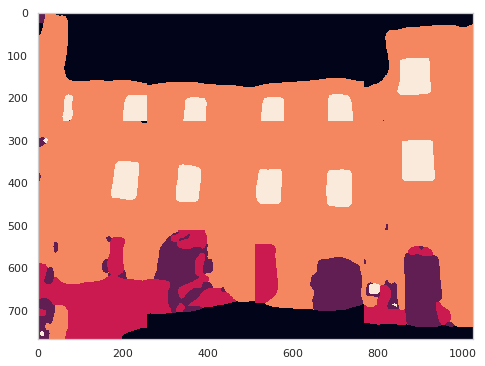

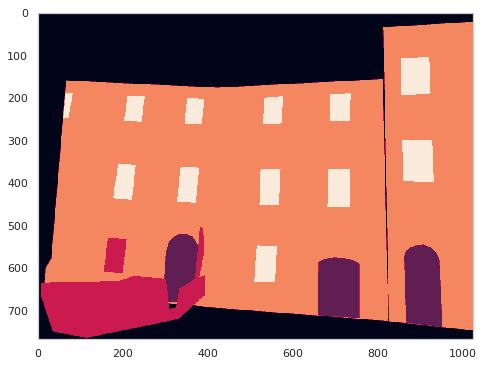

In [34]:
show_img(utils.make_grid(pred.unsqueeze(1).cpu(), nrow=n_row, padding=padding)[0].numpy())
#show_img(utils.make_grid(image_to_show.cpu(), nrow=n_row, padding=padding))
show_img(utils.make_grid(label_to_show.cpu(), nrow=n_row, padding=padding)[0].numpy())

In [35]:
idx_to_show = np.argmin(pred_acc)
n_row = 4
image_to_show, pred, label_to_show = val_img_predict(idx_to_show)
idx_to_show, pred_acc[idx_to_show]

(2, tensor(0.2124))

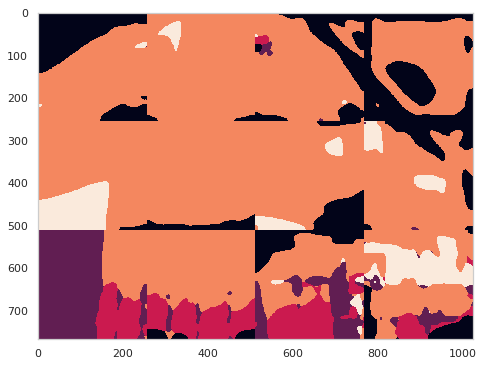

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


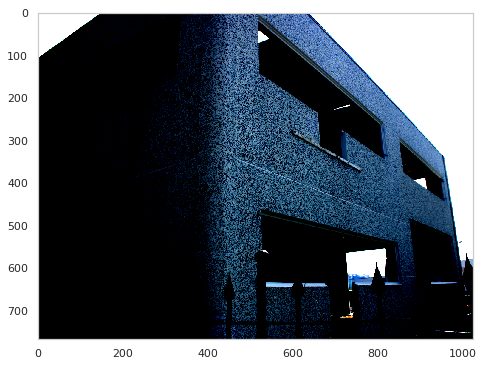

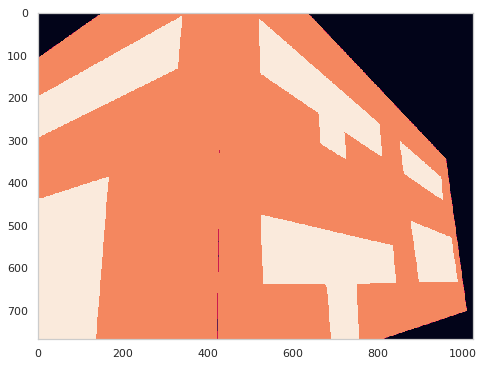

In [36]:
show_img(utils.make_grid(pred.unsqueeze(1).cpu(), nrow=n_row, padding=padding)[0].numpy())
show_img(utils.make_grid(image_to_show.cpu(), nrow=n_row, padding=padding))
show_img(utils.make_grid(label_to_show.cpu(), nrow=n_row, padding=padding)[0].numpy())

In [37]:
idx_to_show = len(pred_acc)-1
n_row = 4
image_to_show, pred, label_to_show = val_img_predict(idx_to_show)
idx_to_show, pred_acc[idx_to_show]

(41, tensor(0.4914))

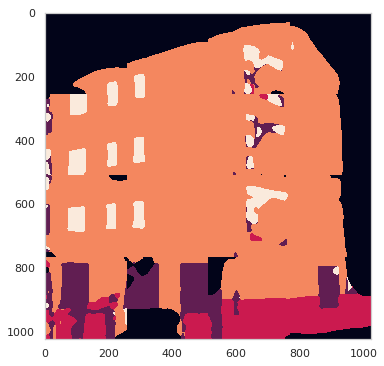

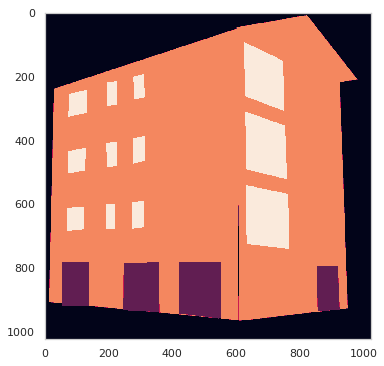

In [38]:
show_img(utils.make_grid(pred.unsqueeze(1).cpu(), nrow=n_row, padding=padding)[0].numpy())
#show_img(utils.make_grid(image_to_show.cpu(), nrow=n_row, padding=padding))
show_img(utils.make_grid(label_to_show.cpu(), nrow=n_row, padding=padding)[0].numpy())